# Clustering my own Spotify Playlist - *Is my most random playlist... that random?*

In this project we will analyze my own Spotify music and apply different unspervised clustering techniques to group the songs according to its features (loudness, tempo, danceability, etc). The data was fetched using the **Spotify API & Spotipy module**, the python script i used to connect to Spotify is available in the following link:[spotify_data_extract.py](https://github.com/Mario-UF/DsProyects/blob/main/Spotify_Clustering/spotify_data_extract.py), and is located in the same directory as this notebook.

# Work in progress (WIP)

**WIP:** *For the time being, we have only applied K-means clustering technique in addition to PCA to do a first exploratory analysis and some visualizations (clustering my playlist in 2 or 8 clusters), but we will explore more clustering techniques, such as DBSCAN (Density-Based Spatial Clustering), Gaussian Mixtures, Hierarchical clustering, Kernel PCA variations, T-SNE, etc. On top of that, we will also include dendrograms and 3D polts to visualize the clusters and draw conclusions. Finally, we will complete the missing story and the conclusions for each step*

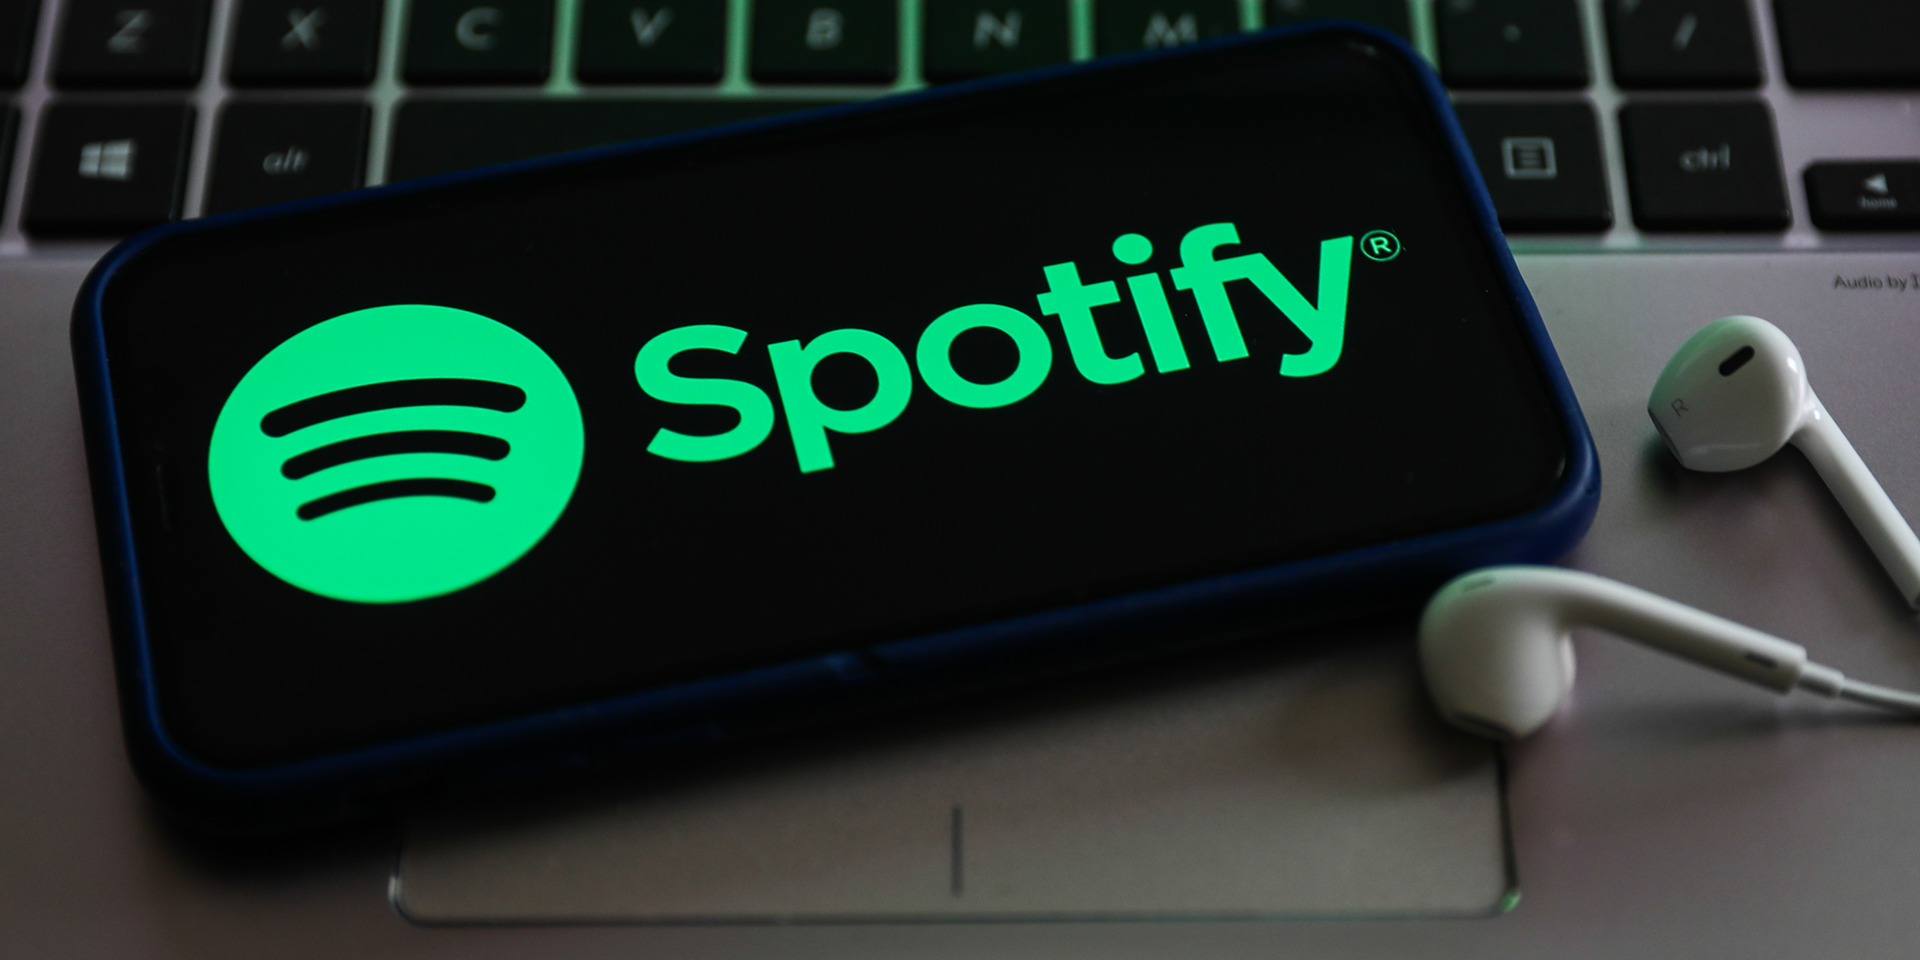

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
sns.set_theme(style='darkgrid')

In [6]:
spotify_df = pd.read_csv('myspotifylist.csv').drop('Unnamed: 0',axis=1)
spotify_df.head(2)

,name,artist,danceability,energy,loudness,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,uri
0,No Brainer,DJ Khaled,0.552,0.760,-4.706,0,1,0.3420,0.0733,0.000000,0.0865,0.639,135.702,260000,5,spotify:track:5WvAo7DNuPRmk4APhdPzi8
1,"Men In Black - From ""Men In Black"" Soundtrack",Will Smith,0.801,0.581,-8.491,5,0,0.0681,0.0968,0.000318,0.0971,0.656,107.545,227267,4,spotify:track:2FK7fxjzQEXD7Z32HSF0Hl


We will drop the varaibles we won't use to cluster our songs.

In [7]:
spotify_df = spotify_df.drop(['name', 'artist','uri'],axis=1)

Since we have different scales among the variables, we need to standarize them to avoid the predominance of the largest ones over the small ones.

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
spotify_df = pd.DataFrame(scaler.fit_transform(spotify_df), columns = spotify_df.columns)

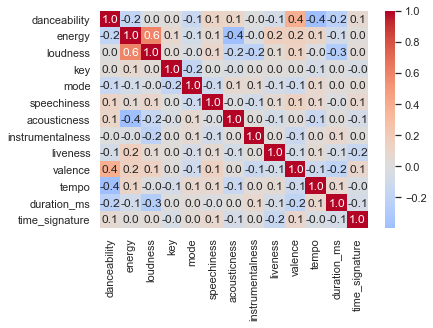

In [336]:
sns.heatmap(spotify_df.corr(), annot=True,fmt='.1f',cmap='coolwarm', center=0);

Let's explore an optimal number of clusters through K-means clustering with different number of clusters. To asses the optimal number we look for a change in trend for inertia score (mean distance to cluster centroids) or pick the highest silhouette score (more precise approach considerng inter and intra cluster distance).

In [26]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertia_scores = []
silhouette_scores = []
clusters = range(2,15)
for i in clusters:
    kmeans = KMeans(n_clusters=i, random_state=123, n_init=10, init='k-means++')
    kmeans.fit(spotify_df)
    inertia_scores.append([i,-kmeans.score(spotify_df)])
    silhouette_scores.append([i,silhouette_score(spotify_df, kmeans.labels_)])
inertia_scores = np.array(inertia_scores)
silhouette_scores = np.array(silhouette_scores)

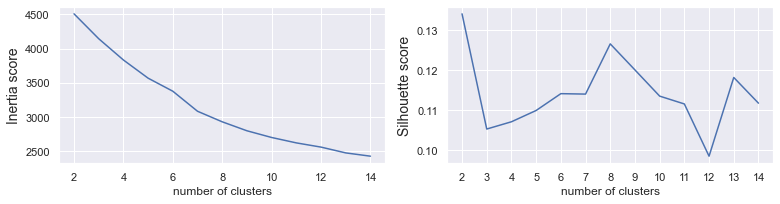

In [27]:
f, ax = plt.subplots(1,2,figsize=(11,3))

sns.lineplot(x=inertia_scores[:,0],y=inertia_scores[:,1],ax=ax[0])
sns.lineplot(x=silhouette_scores[:,0],y=silhouette_scores[:,1],ax=ax[1])
ax[0].set_xlabel('number of clusters')
ax[1].set_xlabel('number of clusters')
ax[0].set_ylabel('Inertia score', fontsize=14)
ax[1].set_ylabel('Silhouette score', fontsize=14)
plt.xticks(clusters)
plt.tight_layout();

Visualizing the Inertia score for different numbers of clusters, we can't distinguish any major change in trend ("elbow") to choose an optimal number of clusters through this method, so we will rely on Silhouette score, wich is a more precise approach. In this case, the best results are obtained with 2 clusters, followed by a configuration of 8 clusters.

In [28]:
kmeans2 = KMeans(n_init=10, random_state=123, n_clusters=2).fit(spotify_df)
kmeans8 = KMeans(n_init=10, random_state=123, n_clusters=8).fit(spotify_df)

## Dimensionality Reduction & Visualization

### PCA

Let's first reduce our dataset to a 2 dimensional space (2 first component) and visualize our clusters:

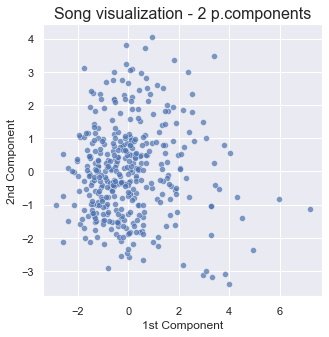

In [149]:
#To-do: Include a scree plot to draw some conclusions and analyse each component composition.

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_data = pca.fit_transform(spotify_df)

plt.figure(figsize=(5,5))
sns.scatterplot(x=pca_data[:,0],y=pca_data[:,1],alpha=0.7)
plt.xlabel('1st Component')
plt.ylabel('2nd Component')
plt.title('Song visualization - 2 p.components',fontsize=16);

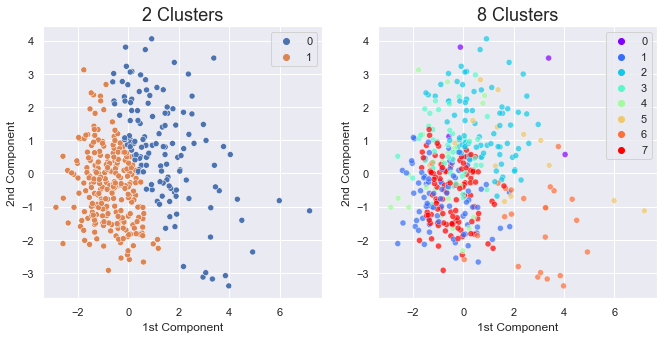

In [144]:
f, ax = plt.subplots(1,2, figsize=(11,5))

sns.scatterplot(x=pca_data[:,0],y=pca_data[:,1],hue=kmeans2.labels_,ax=ax[0])
sns.scatterplot(x=pca_data[:,0],y=pca_data[:,1],alpha=0.7,hue=kmeans8.labels_, palette='rainbow', legend='full',ax=ax[1]);
ax[0].set_xlabel('1st Component')
ax[1].set_xlabel('1st Component')
ax[0].set_ylabel('2nd Component')
ax[1].set_ylabel('2nd Component')
ax[0].set_title('2 Clusters', fontsize=18)
ax[1].set_title('8 Clusters', fontsize=18);

## DBSCAN (Density-Based Spatial Clustering)

### Outlier detection using DBSCAN

The green dots (label equal to -1) represents the outliers depending on the distance (eps) passed to DBSCAN algorithm

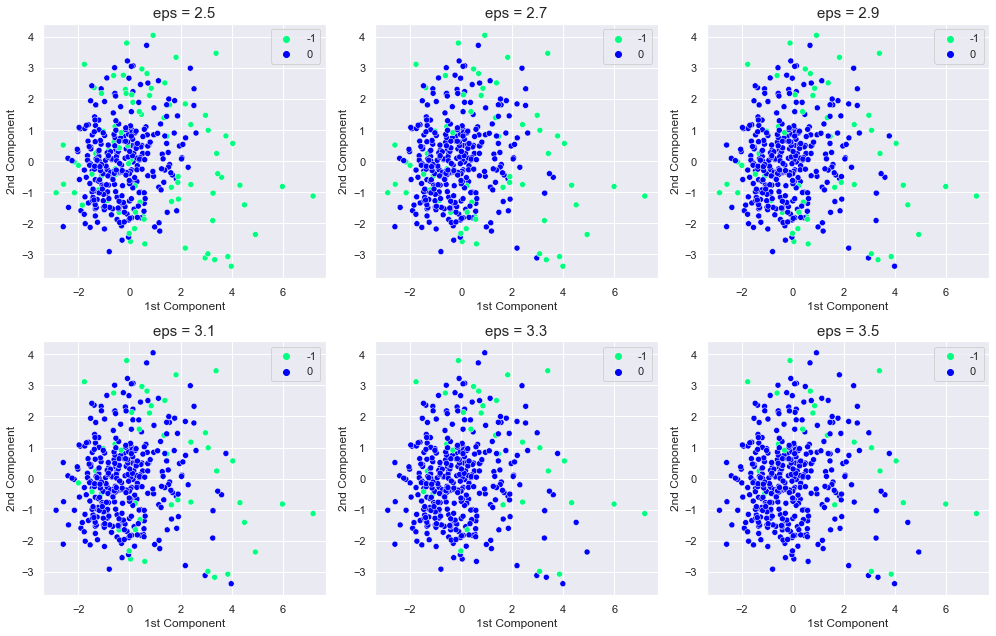

In [166]:
from sklearn.cluster import DBSCAN
#f, ax = plt.subplots(2,3,figsize=(12,8))

f = plt.figure(figsize=(14, 9))

idx=1
for i in np.linspace(2.5,3.5,6):
    db = DBSCAN(eps=i, min_samples=5).fit_predict(spotify_df)
    ax_new = f.add_subplot(2, 3, idx)
    sns.scatterplot(x=pca_data[:,0],y=pca_data[:,1], hue=db,palette='winter_r')
    ax_new.set_title(f'eps = {i}', fontsize=15)
    ax_new.set_xlabel('1st Component')
    ax_new.set_ylabel('2nd Component')
    
    idx += 1

plt.tight_layout()

## Hierarchical Clustering

In [1]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

In [ ]:
AgglomerativeClustering(n_clusters=14, affinity='euclidean', linkage='ward', distance_threshold=0)

## Work in Progress!!